In [317]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette('colorblind')

In [304]:
all_outputs = os.listdir("grammar_outputs/wilcox_replication")
basic_outputs = [output_file for output_file in all_outputs if "basic" in output_file]
basic_effects = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication",output_filename)))
    stim_id = 1
    # get model/construction (subj obj or pp) from filenames
    model_name = output_filename.split(".json")[0][-4:]
    construction_name = output_filename.split(".json")[0].split("_")[1]
    for stim_set in construction_data:
        basic_effects.append({
            "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "gap",
            "wh_effect": stim_set['s_ab']['critical_surprisal'] - stim_set['s_xb']['critical_surprisal']
        })
        basic_effects.append({
                        "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "nogap",
            "wh_effect": stim_set['s_ax']['critical_surprisal'] - stim_set['s_xx']['critical_surprisal']
        })
        stim_id +=1


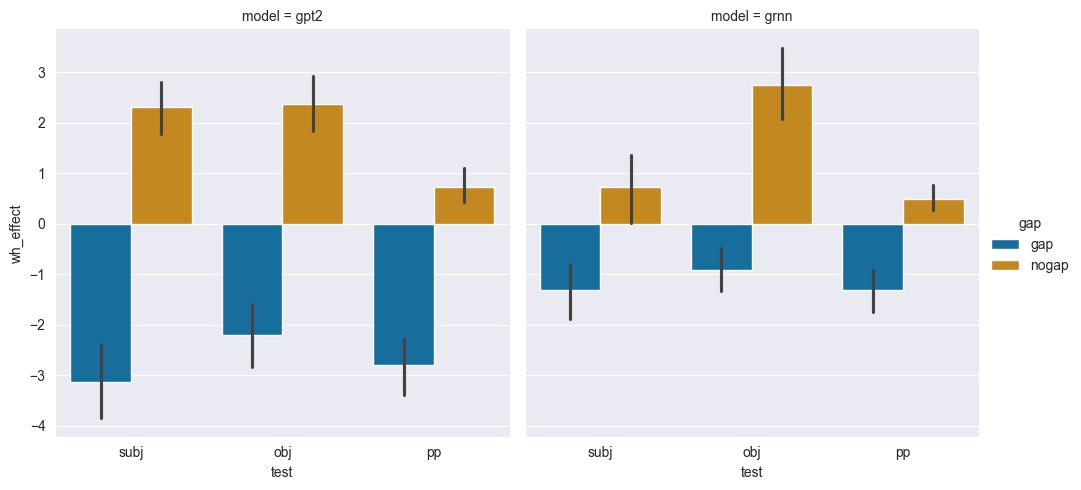

In [305]:
basic_effects = pd.DataFrame(basic_effects)
sns.catplot(x="test", y="wh_effect", hue="gap", data=basic_effects, kind="bar", col = "model",
            estimator="mean")
if "figures" not in os.listdir("."):
    os.mkdir("figures")
plt.savefig("figures/basic_fg.png")

Wilcox et al: run "Linear mixed-effects models on raw surprisal values with sum-coded conditions and by-item random slopes". We're looking for a significantly negative interaction term between the presence & absence of gaps.

In order to do this, we need to re-read the files for raw surprisal values and make features to put into our regression model (wh/that, gap/nogap)

In [376]:
def modify_base_dict(sentence_key, stim_set, base_dict):
    sent_copy = base_dict.copy()
    # replace 0 with -1 for island
    if sentence_key == "s_ab":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_xb":
        sent_copy['wh'] = 0
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_ax":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 0
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    else: # s_xx
        sent_copy['wh'] = 0
        sent_copy['gap'] = 0
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    return sent_copy

In [370]:
basic_surprisals = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication",output_filename)))
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    for i in construction_data:
        model_name = output_filename.split(".json")[0][-4:]
        construction_name = output_filename.split(".json")[0].split("_")[1]
        for stim_set in construction_data:
            base_info = {
                "item": stim_id,
                "model": model_name,
                "test": construction_name
            }
            basic_surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
            stim_id +=1

In [308]:
basic_surprisals = pd.DataFrame(basic_surprisals)

We now fit mixed-effects models for each model & condition

In [309]:
from pymer4.models import Lmer


In [310]:
def fit_regression_model(lm, condition, surprisal_data, formula):
    condition_data = surprisal_data[(surprisal_data['model'] == lm) & (surprisal_data['test'] == condition)]
    model = Lmer(formula, data = condition_data)
    model.fit()
    return model.summary()

In [311]:
import itertools

In [334]:
conditions, models = basic_surprisals['test'].unique(), basic_surprisals['model'].unique()
interaction_results = []
basic_formula = "surprisal ~ wh * gap + (wh+gap || item)"
for condition, model in itertools.product(conditions, models):
    summary = fit_regression_model(model, condition, basic_surprisals)
    result = summary[['Estimate', 'P-val', 'Sig']].iloc[-1]
    result['model'] = model
    result['condition'] = condition
    interaction_results.append(result)


Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -25968.787 	 AIC: 51953.574

Random effects:

                 Name     Var    Std
item      (Intercept)   7.845  2.801
item.1             wh   0.097  0.311
item.2            gap  10.290  3.208
Residual                2.683  1.638

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -25968.787 	 AIC: 51953.574

Random effects:

                 Name     Var    Std
item      (Intercept)   7.845  2.801
item.1             wh   0.097  0.311
item.2            gap  10.290  3.208
Residual                2.683  1.638

No random effect correlations specified

Fixed effects:

boundary (singular) fit:

We have a negative interaction term, and the result is statistically significant (really low p-values get rounded down to 0).

In [318]:
pd.DataFrame(interaction_results)

,Estimate,P-val,Sig,model,condition
wh:gap,-1.362,0.0,***,gpt2,subj
wh:gap,-0.509,0.0,***,grnn,subj
wh:gap,-1.145,0.0,***,gpt2,obj
wh:gap,-0.914,0.0,***,grnn,obj
wh:gap,-0.885,0.0,***,gpt2,pp
wh:gap,-0.448,0.0,***,grnn,pp


## Plotting the Island data

In [377]:
from generate_corpora import corpus_from_json

In [378]:
def island_effects_for_model(model_name):
    # we could make this a little more generic and put it in an analysis utils thing 
    obj_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
    that_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)
    island_effects = []
    for condition, data in zip(("control", "that-island"), (obj_tuples, that_tuples)):
        for item in data:
            island_effects.append({
                "model": model_name,
                "condition": condition,
                "gap": "gap",
                "wh_effect": item.s_ab.critical_surprisal - item.s_xb.critical_surprisal
            })
            island_effects.append({
                "model": model_name,
                "condition": condition,
                "gap": "nogap",
                "wh_effect": item.s_ax.critical_surprisal - item.s_xx.critical_surprisal
            })
    return island_effects

grnn_cnp_island_effects = island_effects_for_model("grnn")
gpt2_cnp_island_effects = island_effects_for_model("gpt2")
island_effects = pd.DataFrame(grnn_cnp_island_effects + gpt2_cnp_island_effects)

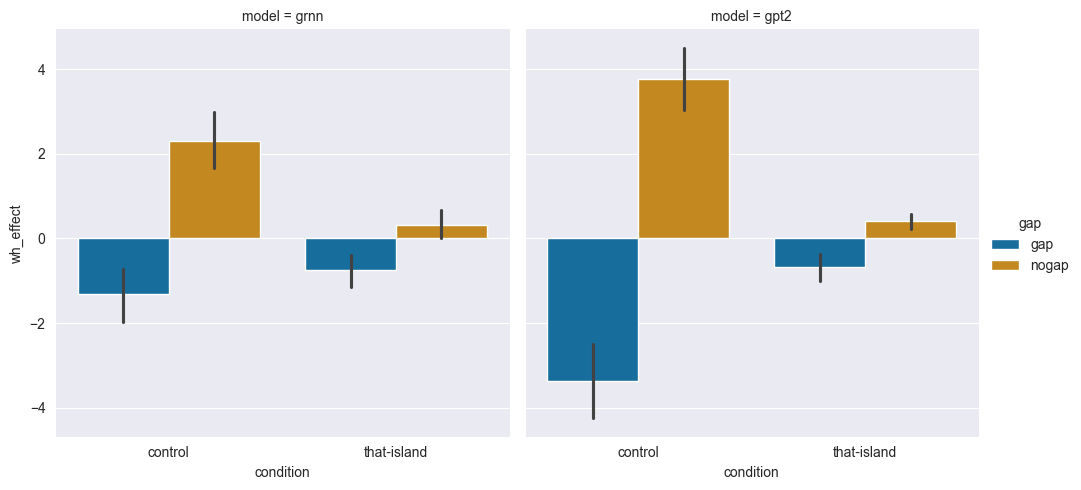

In [379]:
sns.catplot(x="condition", y="wh_effect", hue="gap", data=island_effects, kind="bar", col = "model",
            estimator="mean")
plt.savefig("figures/wilcox_cnp_island.png")

In [380]:
model = "gpt2"
control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)

def island_surprisals(condition_name, tuples, model_name):
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    surprisals = []
    for stim_set in tuples:
        stim_set = stim_set.to_dict()
        base_info = {
            "item": stim_id,
            "model": model_name,
            "island": condition_name
        }
        surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
        surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
        stim_id +=1
    return surprisals

In [381]:
all_island_surprisals = []
for model_name in ["gpt2", "grnn"]:
    control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
    island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)
    all_island_surprisals += island_surprisals("control", control_tuples, model_name)
    all_island_surprisals += island_surprisals("island", island_tuples, model_name)

In [382]:
all_island_surprisals = pd.DataFrame(all_island_surprisals)


The three-way interaction term (filler x gap x island) is significant for both models.

In [383]:
grnn_island = all_island_surprisals[all_island_surprisals['model'] == 'grnn']
model = Lmer("surprisal~wh*gap*island+(gap||item)", data = grnn_island)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -569.953 	 AIC: 1161.906

Random effects:

                 Name     Var    Std
item      (Intercept)  33.538  5.791
item.1            gap  64.841  8.052
Residual                3.803  1.950

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -569.953 	 AIC: 1161.906

Random effects:

                 Name     Var    Std
item      (Intercept)  33.538  5.791
item.1            gap  64.841  8.052
Residual                3.803  1.950

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),16.030,13.767,18.293,1.155,31.625,13.881,0.000,***
wh,2.298,1.276,3.319,0.521,160.061,4.409,0.000,***
gap,6.210,3.057,9.363,1.609,31.786,3.861,0.001,***
islandisland,-2.362,-3.384,-1.341,0.521,160.061,-4.532,0.000,***
wh:gap,-3.621,-5.066,-2.177,0.737,160.061,-4.913,0.000,***
wh:islandisland,-1.976,-3.420,-0.531,0.737,160.061,-2.680,0.008,**
gap:islandisland,2.226,0.782,3.671,0.737,160.061,3.020,0.003,**
wh:gap:islandisland,2.563,0.520,4.606,1.042,160.061,2.459,0.015,*


In [384]:
gpt2_island = all_island_surprisals[all_island_surprisals['model'] == 'gpt2']
model = Lmer("surprisal~wh*gap*island+(gap||item)", data = gpt2_island)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -543.821 	 AIC: 1109.641

Random effects:

                 Name     Var    Std
item      (Intercept)  19.777  4.447
item.1            gap  16.278  4.035
Residual                3.727  1.931

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -543.821 	 AIC: 1109.641

Random effects:

                 Name     Var    Std
item      (Intercept)  19.777  4.447
item.1            gap  16.278  4.035
Residual                3.727  1.931

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),14.503,12.707,16.299,0.916,34.766,15.830,0.000,***
wh,3.757,2.745,4.768,0.516,158.233,7.281,0.000,***
gap,2.692,0.888,4.497,0.921,45.769,2.925,0.005,**
islandisland,-1.993,-3.005,-0.982,0.516,158.233,-3.864,0.000,***
wh:gap,-7.129,-8.559,-5.699,0.730,158.233,-9.770,0.000,***
wh:islandisland,-3.356,-4.786,-1.926,0.730,158.233,-4.599,0.000,***
gap:islandisland,2.634,1.204,4.064,0.730,158.233,3.610,0.000,***
wh:gap:islandisland,6.064,4.041,8.086,1.032,158.233,5.876,0.000,***
